# Exercise 6 + Homework 3: MLPs + Dropout + CNNs

Much of this was taken from DS-GA 1011 course from last semester.

### Data things

We're doing a sentiment classification task. So first load the Stanford Sentiment Treebank data.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import re
import random

random.seed(1)
sst_home = 'data/trees'

# Let's do 2-way positive/negative classification instead of 5-way
easy_label_map = {0:0, 1:0, 2:None, 3:1, 4:1}
    # so labels of 0 and 1 in te 5-wayclassificaiton are 0 in the 2-way. 3 and 4 are 1, and 2 is none
    # because we don't have a neautral class. 

PADDING = "<PAD>"
UNKNOWN = "<UNK>"
max_seq_length = 20

def load_sst_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data
     
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

And extract bag-of-words feature vectors. For speed, we'll only use words that appear at least 25 times in the training set, leaving us with |V|=1254.

In [2]:
import collections
import numpy as np

def tokenize(string):
    return string.split()

def build_dictionary(training_datasets):
    """
    Extract vocabulary and build dictionary.
    """  
    word_counter = collections.Counter()
    for i, dataset in enumerate(training_datasets):
        for example in dataset:
            word_counter.update(tokenize(example['text']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))

    return word_indices, len(vocabulary)

def sentences_to_padded_index_sequences(word_indices, datasets):
    """
    Annotate datasets with feature vectors. Adding right-sided padding. 
    """
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['text_index_sequence'] = torch.zeros(max_seq_length)

            token_sequence = tokenize(example['text'])
            padding = max_seq_length - len(token_sequence)

            for i in range(max_seq_length):
                if i >= len(token_sequence):
                    index = word_indices[PADDING]
                    pass
                else:
                    if token_sequence[i] in word_indices:
                        index = word_indices[token_sequence[i]]
                    else:
                        index = word_indices[UNKNOWN]
                example['text_index_sequence'][i] = index

            example['text_index_sequence'] = example['text_index_sequence'].long().view(1,-1)
            example['label'] = torch.LongTensor([example['label']])


word_to_ix, vocab_size = build_dictionary([training_set])
sentences_to_padded_index_sequences(word_to_ix, [training_set, dev_set, test_set])

We want to feed data to our model in mini-batches so we need a data iterator that will "batchify" the data. We 

In [3]:
# This is the iterator we'll use during training. 
# It's a generator that gives you one batch at a time.
def data_iter(source, batch_size):
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while True:
        start += batch_size
        if start > dataset_size - batch_size:
            # Start another epoch.
            start = 0
            random.shuffle(order)   
        batch_indices = order[start:start + batch_size]
        yield [source[index] for index in batch_indices]

# This is the iterator we use when we're evaluating our model. 
# It gives a list of batches that you can then iterate through.
def eval_iter(source, batch_size):
    batches = []
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while start < dataset_size - batch_size:
        start += batch_size
        batch_indices = order[start:start + batch_size]
        batch = [source[index] for index in batch_indices]
        batches.append(batch)
        
    return batches

# The following function gives batches of vectors and labels, 
# these are the inputs to your model and loss function
def get_batch(batch):
    vectors = []
    labels = []
    for dict in batch:
        vectors.append(dict["text_index_sequence"])
        labels.append(dict["label"])
    return vectors, labels


### Model time!

We need to define an evaluation function,

In [4]:
def evaluate(model, data_iter):
    model.eval()
    correct = 0
    total = 0
    for i in range(len(data_iter)):
        vectors, labels = get_batch(data_iter[i])
        vectors = Variable(torch.stack(vectors).squeeze())
        labels = torch.stack(labels).squeeze()
        output = model(vectors)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    return correct / float(total)

Below is a multilayer perceptron classifier.

What hyperparameters do you think would work well?

In [5]:
# A Multi-Layer Perceptron (MLP)
class MLPClassifier(nn.Module): # inheriting from nn.Module!
    
    def __init__(self, input_size, embedding_dim, hidden_dim, num_labels, dropout_prob):
        super(MLPClassifier, self).__init__()
        
        self.embed = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(p=dropout_prob)
            
        self.linear_1 = nn.Linear(embedding_dim, hidden_dim) 
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_3 = nn.Linear(hidden_dim, num_labels)
        self.init_weights()
        
    def forward(self, x):
        # Pass the input through your layers in order
        out = self.embed(x)
        out = self.dropout(out)
        out = torch.sum(out, dim=1)
        out = F.relu(self.linear_1(out))
        out = F.relu(self.linear_2(out))
        out = self.dropout(self.linear_3(out))
        return out

    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.linear_1, self.linear_2]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

We now define our training loop,

In [6]:
def training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter):
    step = 0
    for i in range(num_train_steps):
        model.train()
        vectors, labels = get_batch(next(training_iter))
        vectors = Variable(torch.stack(vectors).squeeze())
        labels = Variable(torch.stack(labels).squeeze())

        model.zero_grad()
        output = model(vectors)

        lossy = loss(output, labels)
        lossy.backward()
        optimizer.step()

        if step % 100 == 0:
            print( "Step %i; Loss %f; Train acc: %f; Dev acc %f" 
                %(step, lossy.data[0], evaluate(model, train_eval_iter), evaluate(model, dev_iter)))

        step += 1

Let's define our hyperparameters

In [7]:
# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

Modify these hyperparameters to try to achieve approximately 80% dev accuracy.

In [51]:
# hidden_dim = 20
# embedding_dim = 100
# learning_rate = 0.1
# dropout_prob = 0.0

hidden_dim = 50
embedding_dim = 300
learning_rate = 0.001
dropout_prob = 0.1

Finally, we can build and train our model!

In [52]:
model = MLPClassifier(input_size, embedding_dim, hidden_dim, num_labels, dropout_prob)
    
# Loss and Optimizer
loss = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
training_iter = data_iter(training_set, batch_size)
train_eval_iter = eval_iter(training_set[0:500], batch_size)
dev_iter = eval_iter(dev_set[0:500], batch_size)
training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter)

Step 0; Loss 0.680765; Train acc: 0.538000; Dev acc 0.538000
Step 100; Loss 0.576523; Train acc: 0.754000; Dev acc 0.716000
Step 200; Loss 0.286751; Train acc: 0.862000; Dev acc 0.754000
Step 300; Loss 0.391350; Train acc: 0.914000; Dev acc 0.774000
Step 400; Loss 0.234929; Train acc: 0.934000; Dev acc 0.772000
Step 500; Loss 0.087622; Train acc: 0.968000; Dev acc 0.784000
Step 600; Loss 0.226893; Train acc: 0.980000; Dev acc 0.764000
Step 700; Loss 0.028815; Train acc: 0.986000; Dev acc 0.780000
Step 800; Loss 0.012009; Train acc: 0.986000; Dev acc 0.780000
Step 900; Loss 0.077377; Train acc: 0.992000; Dev acc 0.800000


Let's see how it performs on the held out test set,

In [10]:
# Test the model
#test_iter = eval_iter(test_set, batch_size)
#test_acc = evaluate(model, test_iter)
#print('Accuracy of the CBOW on the test data: %f' % (test_acc))

<br>
This model does okay. It doesn't do that well. Lets try and define a Convolutional Neural Network to try and improve performance.

In [11]:
class TextCNN(nn.Module):
    def __init__(self, input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob):
        super(TextCNN, self).__init__()
        
        self.embed = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.dropout2 = nn.Dropout(p = dropout_prob)
        self.conv1 = nn.Conv2d(1, n_filters, (window_size, embedding_dim)) 
        self.fc1 = nn.Linear(n_filters, num_labels)
        self.init_weights()
        
    def forward(self, x):
        # Pass the input through your layers in order
        out = self.embed(x)
        out = self.dropout(out)
        out = out.unsqueeze(1)
        out = self.conv1(out).squeeze(3)
        out = F.relu(out)
        out = F.max_pool1d(out, out.size(2)).squeeze(2)
        out = self.fc1(self.dropout2(out))
        return out

    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.fc1]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

Lets train our Conv Net. Lets redefine the hyperparameters here. You need to modify these as well! Try to achieve approximately 80% dev accuracy.

In [68]:
# window_size = 2
# n_filters = 5
# embedding_dim = 100
# learning_rate = 0.1
# dropout_prob = 0.0

window_size = 3#3
n_filters = 100#100
embedding_dim = 100#100
learning_rate = 0.001
dropout_prob = 0.3

# 3, 100,100,0.001,0.5

Lets build and train this model:

In [69]:
cnn_model = TextCNN(input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob)
    
# Loss and Optimizer
loss = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

# Train the model
training_iter = data_iter(training_set, batch_size)
train_eval_iter = eval_iter(training_set[0:500], batch_size)
dev_iter = eval_iter(dev_set[0:500], batch_size)
training_loop(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter)

Step 0; Loss 0.691354; Train acc: 0.536000; Dev acc 0.540000
Step 100; Loss 0.686284; Train acc: 0.672000; Dev acc 0.632000
Step 200; Loss 0.640667; Train acc: 0.714000; Dev acc 0.694000
Step 300; Loss 0.437982; Train acc: 0.820000; Dev acc 0.738000
Step 400; Loss 0.468584; Train acc: 0.862000; Dev acc 0.744000
Step 500; Loss 0.419163; Train acc: 0.914000; Dev acc 0.756000
Step 600; Loss 0.425658; Train acc: 0.958000; Dev acc 0.776000
Step 700; Loss 0.090484; Train acc: 0.974000; Dev acc 0.774000
Step 800; Loss 0.066164; Train acc: 0.980000; Dev acc 0.772000
Step 900; Loss 0.039916; Train acc: 0.990000; Dev acc 0.792000


Lets evaluate this on the held out test set

In [14]:
# Test the model
#test_iter = eval_iter(test_set, batch_size)
#test_acc = evaluate(cnn_model, test_iter)
#print('Accuracy of the CNN model on the test data: %f' % (test_acc))

# Homework 3 (10pts)

### Please construct all of your plots in the ipython notebook using something like matplotlib. Provide all answers in the ipython notebook. We will not grade anything other than the ipython notebook

Questions:

1. Provide plots of varying hidden_dim, embedding_dim, LR, and dropout for deep CBOW (0.75pts each). 
2. Describe how each hyperparameter affects performance on train and dev (1.5pts total).
3. Provide plots of varying embedding_dim, window_size, num_filters, LR, and dropout for CNN (0.6pts for each HP).
4. Describe how each hyperparameter affects performance on train and dev (1.5pts total).
5. Write down an hyperparameter configuration for CBOW that achieves 80 dev within the first 1000 train steps. Make sure this configuration is run in your ipython notebook when it is submitted (0.5pts).
6. Write down an hyperparameter configuration for CNN that achieves 80 dev within the first 1000 train steps. Make sure this configuration is run in your ipython notebook when it is submitted (0.5pts).

To help expedite the process, I used the same codes and ran batches on the HPC to get the desired results. I have used the results here to build the plots (results stored in the attached python pickle files - 'CBOW_P1' and 'CNN_P1')

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [38]:
fcbow = open('CBOW_P1')
cbow = pickle.load(fcbow)
# print(cbow)

fcnn = open('CNN_P1')
cnn = pickle.load(fcnn)
# print(cnn)

def getSimpleLastValues(dictionary,var,i):
    x = list(keys for keys in sorted(dictionary[var]))
    y = [dictionary[var][key][-1][i] for key in sorted(dictionary[var])]
    return x, y

Q1. Plotting the final values by changing a single variable a time - Training


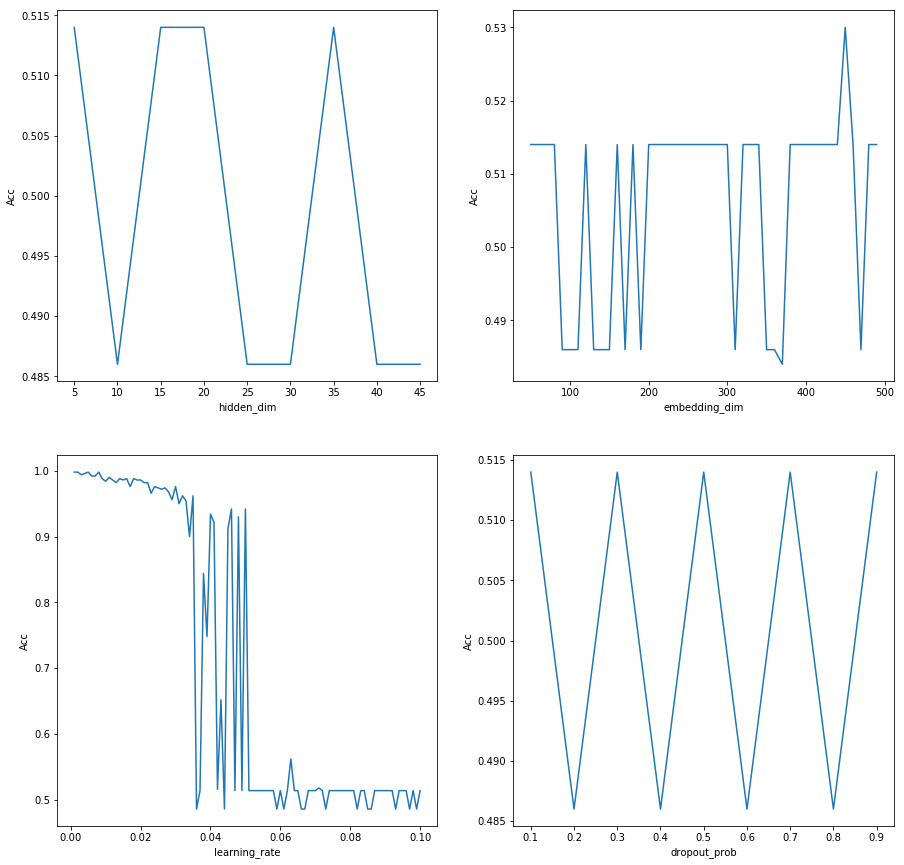

In [39]:
print('Q1. Plotting the final values by changing a single variable a time - Training')

hypers = ['hidden_dim','embedding_dim','learning_rate','dropout_prob']
plt.figure(1,figsize=(15, 15))
for idx,var in enumerate(hypers):
    plt.subplot(2, 2, idx+1)
    x,y = getSimpleLastValues(cbow,var,0)
    plt.plot(x,y)
    plt.ylabel('Acc')
    plt.xlabel(var)

Q1. Plotting the final values by changing a single variable a time - Dev


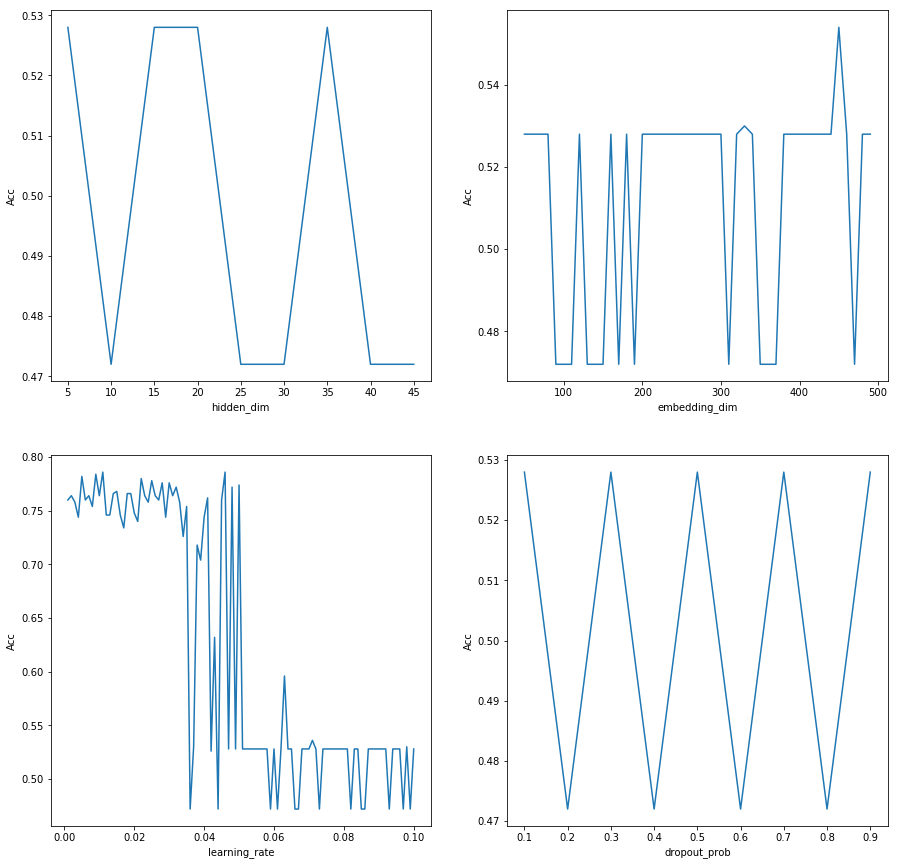

In [40]:
print('Q1. Plotting the final values by changing a single variable a time - Dev')

hypers = ['hidden_dim','embedding_dim','learning_rate','dropout_prob']
plt.figure(1,figsize=(15, 15))
for idx,var in enumerate(hypers):
    plt.subplot(2, 2, idx+1)
    x,y = getSimpleLastValues(cbow,var,1)
    plt.plot(x,y)
    plt.ylabel('Acc')
    plt.xlabel(var)

Q2. Here we see that the accuracy varies considerably with the window size though it finds a good estimate around the value of 15-20. The embedding dimension give good consistent results for values around 200-300 but the best final accuracy is observed close to 480. The dropout_prob hyper-param introduces randomness and helps generalize results, however, due to the randomness, the fluctuations are quite uninterpretable in the graph. Maybe with more iterations and epochs, there would be some stability in the results. Also, a better way to look at it would be to see the trend accuracy in training (plotted later) rather than just the final accuracy. The learning rate is the most interpretable as it shows how with low learning rate we see high accuracy but as we increase the learning rate, the model is not trained well.

We see very similar trends in training and dev sets for the CBOW model

Q3. Plotting the final values by changing a single variable a time - Training


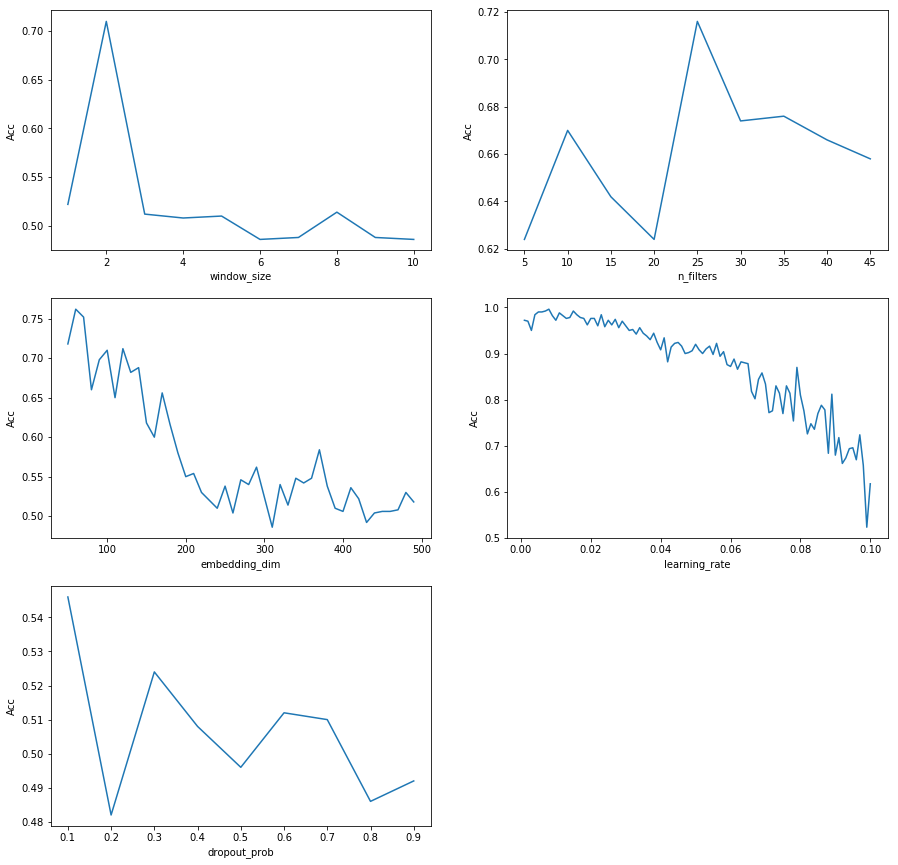

In [41]:
print('Q3. Plotting the final values by changing a single variable a time - Training')

hypers = ['window_size','n_filters','embedding_dim','learning_rate','dropout_prob']
plt.figure(1,figsize=(15, 15))
for idx,var in enumerate(hypers):
    plt.subplot(3, 2, idx+1)
    x,y = getSimpleLastValues(cnn,var,0)
    plt.plot(x,y)
    plt.ylabel('Acc')
    plt.xlabel(var)

Q3. Plotting the final values by changing a single variable a time - Dev


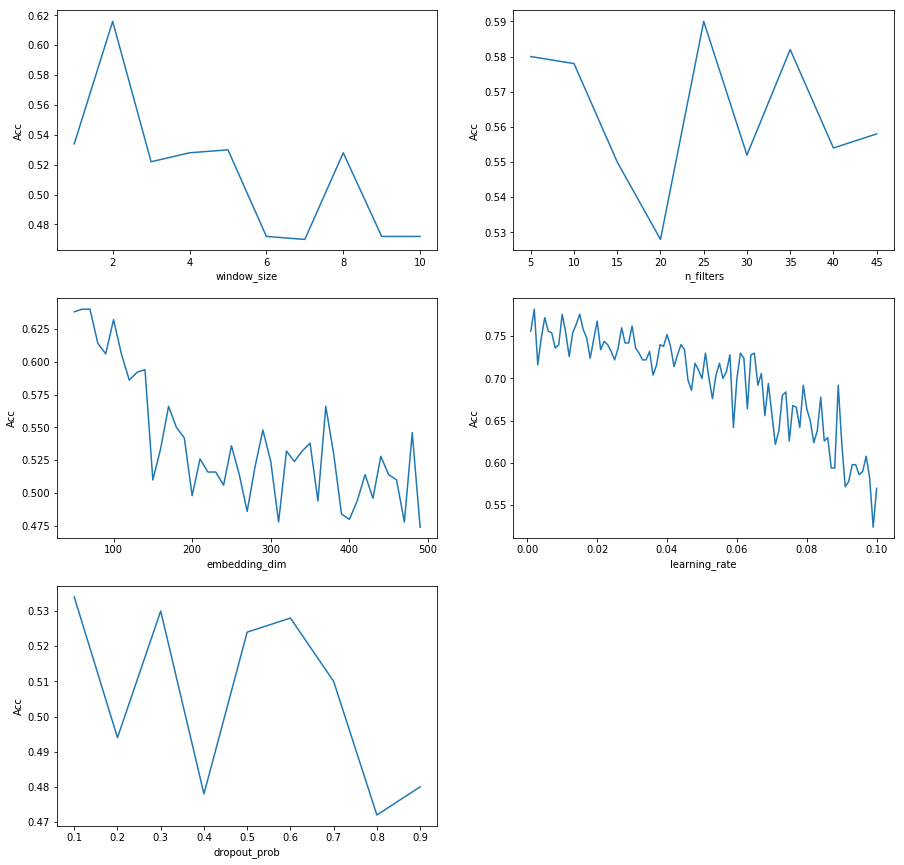

In [42]:
print('Q3. Plotting the final values by changing a single variable a time - Dev')

hypers = ['window_size','n_filters','embedding_dim','learning_rate','dropout_prob']
plt.figure(1,figsize=(15, 15))
for idx,var in enumerate(hypers):
    plt.subplot(3, 2, idx+1)
    x,y = getSimpleLastValues(cnn,var,1)
    plt.plot(x,y)
    plt.ylabel('Acc')
    plt.xlabel(var)

Q4. High accuracy is achieved with low window size which suggests that it is best to use bi-gram and tri-gram like models and increasing the window size increases the complexity of the model too much for it to learn and generalize well. The dip in accuracy in n_filters at 20 and 30 is weird (maybe stabilize with more training/epochs), but the general trend is higher number of filters is better till a certain point, best at 25. The embedding_dim param is best at 100 and gradually decreases the accuracy as it is increased probably due to more sparsity involved with higher values and less training data. The learning rate here again is the most interpretable as it shows how with low learning rate we see high accuracy but as we increase the learning rate, the model is not trained well/generalizes well. The dropout here is more consistent that in the CBOW model and we see a general high accuracry in the values near 0.5-0.6, i.e dropping 50% of the weights in training.

For the CNN model, we see a general smoother curves in training but not in dev set might be due to better convergence and lesser generalization as we can see from the differences in the dropout_prob graphs.

Here I also show the trend of the accuracy across the training steps. Each plot in each subfigure corresponds to a configuration (see legend). 

In [31]:
def getHistoryValues(dictionary,var):
    numOfVals = list(keys for keys in sorted(dictionary[var]))
    x = list(range(10))
    ys = []
    for k in numOfVals:
        ys.append([hist[1] for hist in dictionary[var][k]])
    return x,ys,numOfVals

Plotting CBOW history values Dev----------------------------------
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'hidden_dim')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'embedding_dim')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'learning_rate')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'dropout_prob')


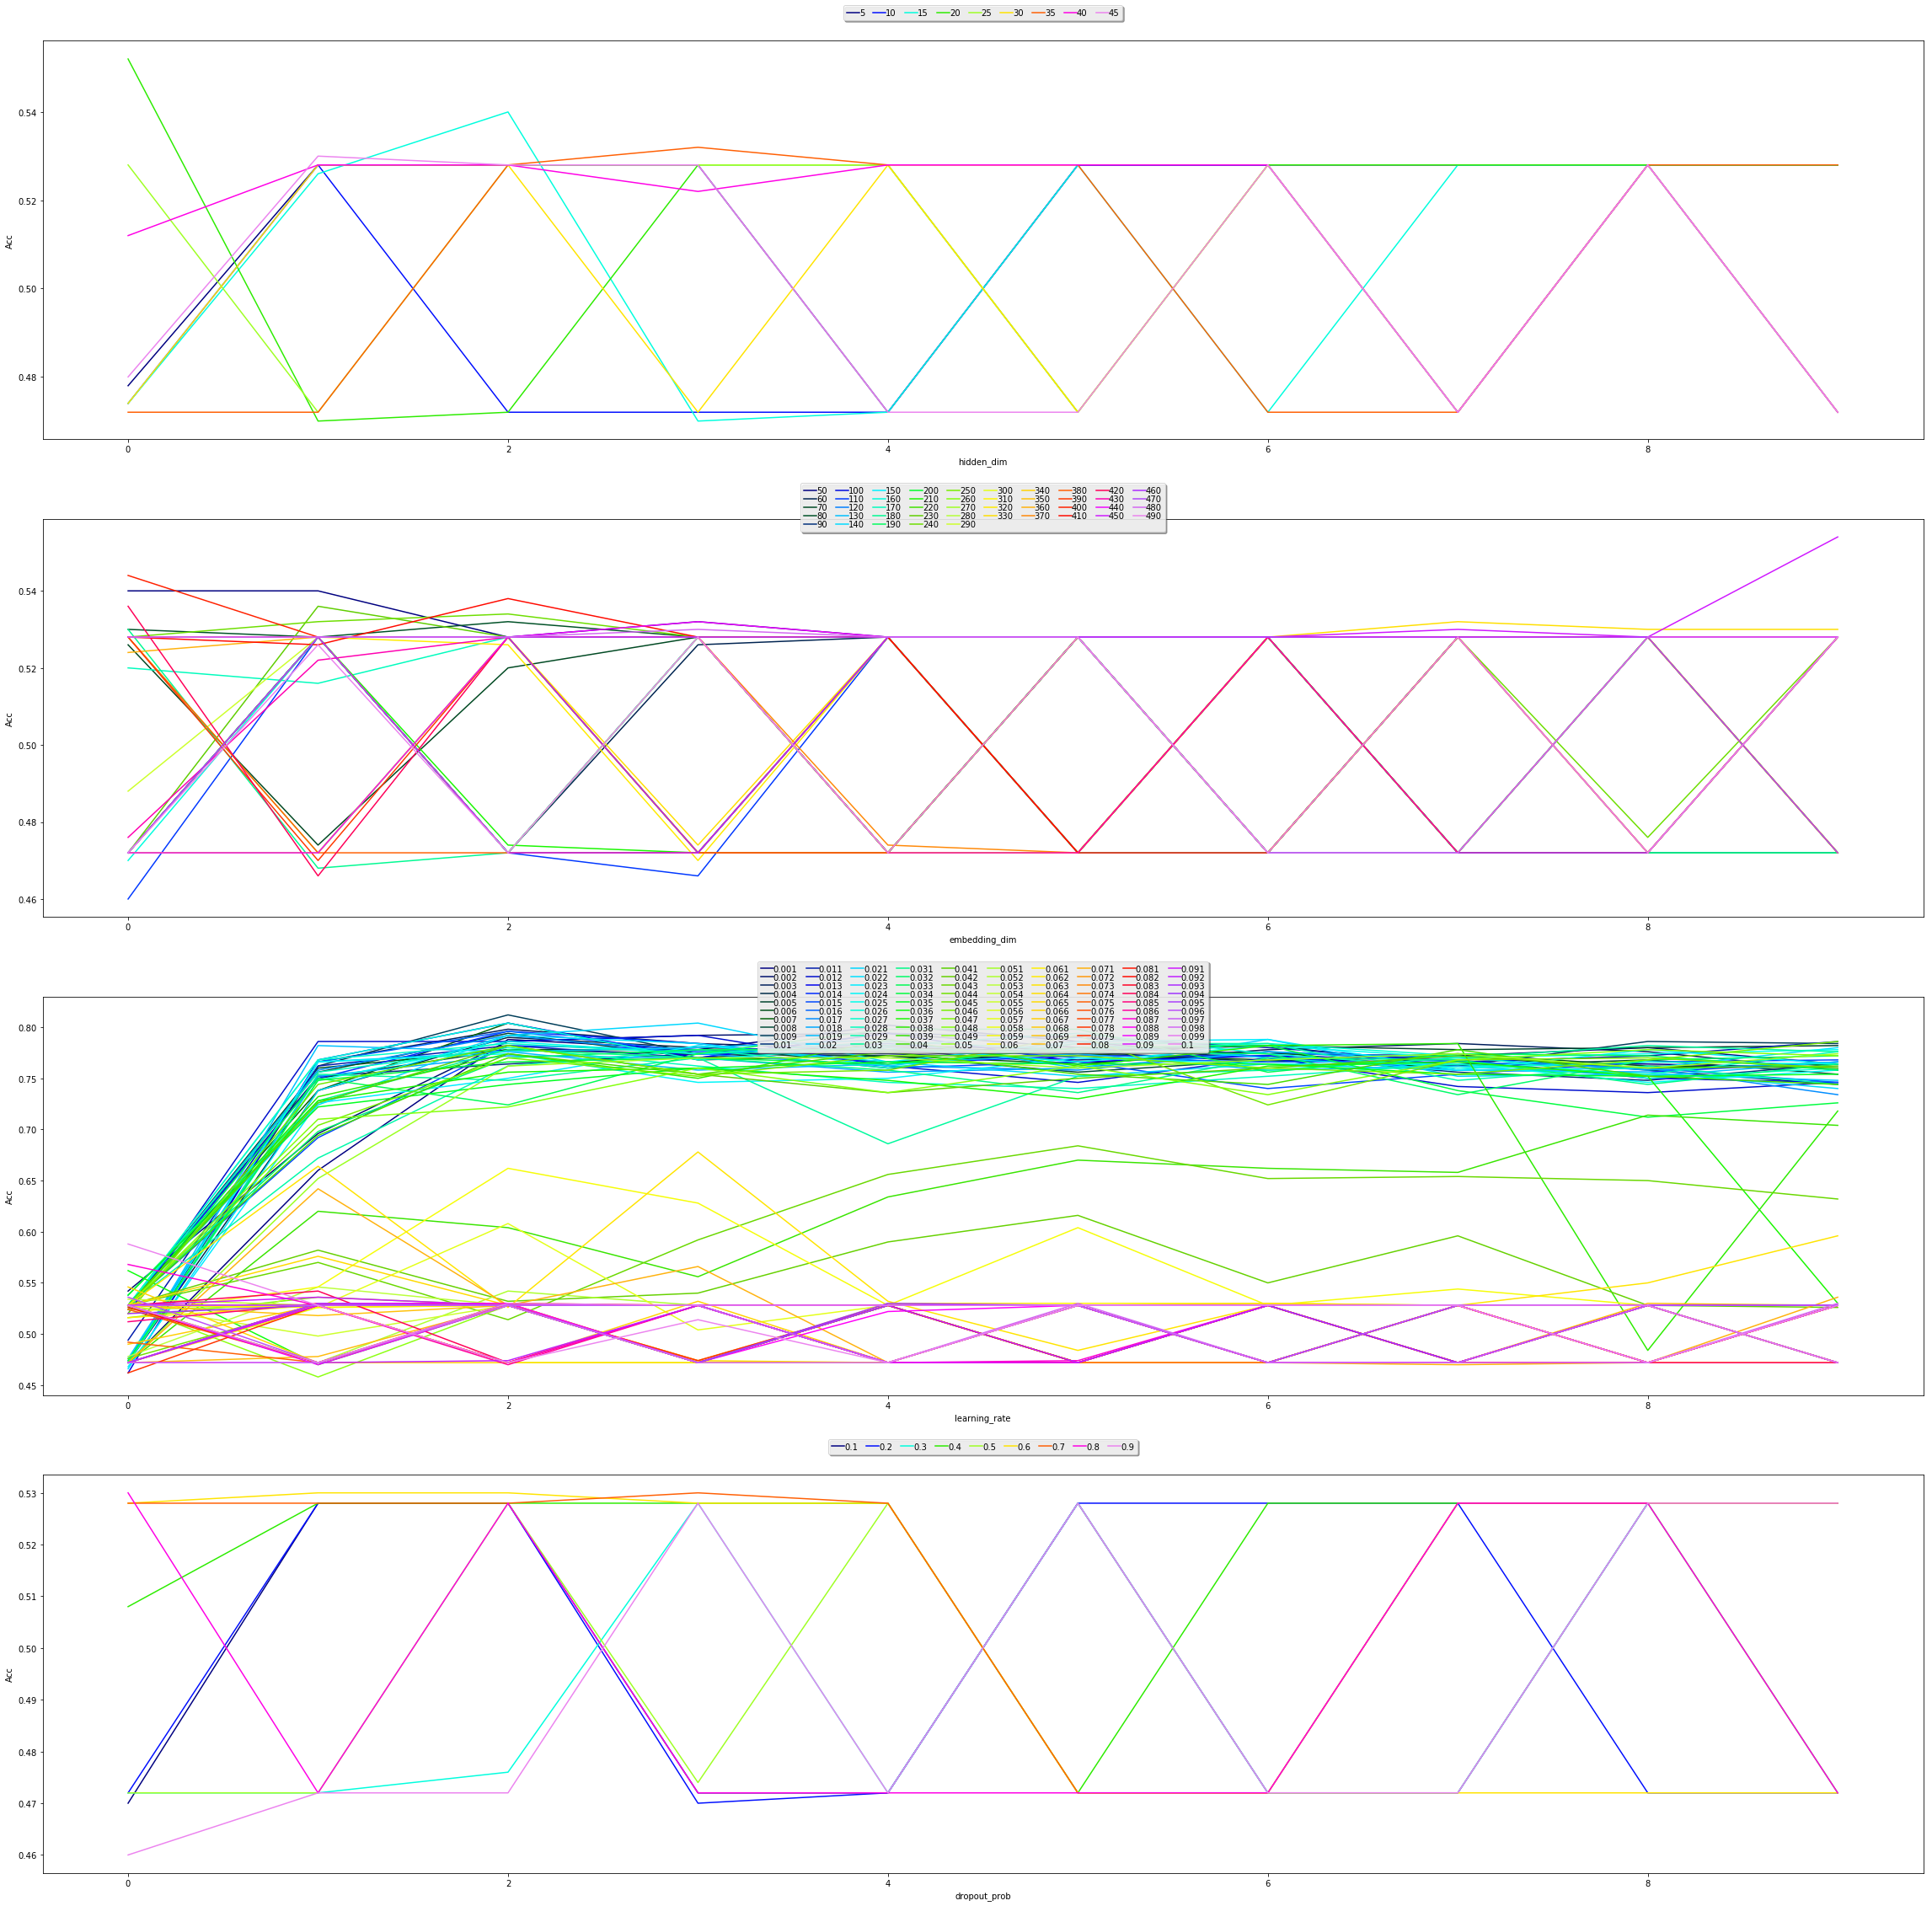

In [43]:
print("Plotting CBOW history values Dev----------------------------------")

hypers = ['hidden_dim','embedding_dim','learning_rate','dropout_prob']
plt.figure(1,figsize=(40, 40))
for idx,var in enumerate(hypers):
    print("Plotting accuracy history across variables (different lines) with respect to train steps - ",var)
    x,ys,numOfVals = getHistoryValues(cbow,var)
    labels = [str(val) for val in numOfVals]
    plt.subplot(4, 1, idx+1)
    num_plots = len(ys)
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

    for y in ys:
        plt.plot(x,y)

    plt.ylabel('Acc')
    plt.xlabel(var)
    
    plt.legend(labels, ncol=10, loc='upper center', 
           bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

Plotting CNN history values Dev----------------------------------
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'window_size')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'n_filters')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'embedding_dim')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'learning_rate')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'dropout_prob')


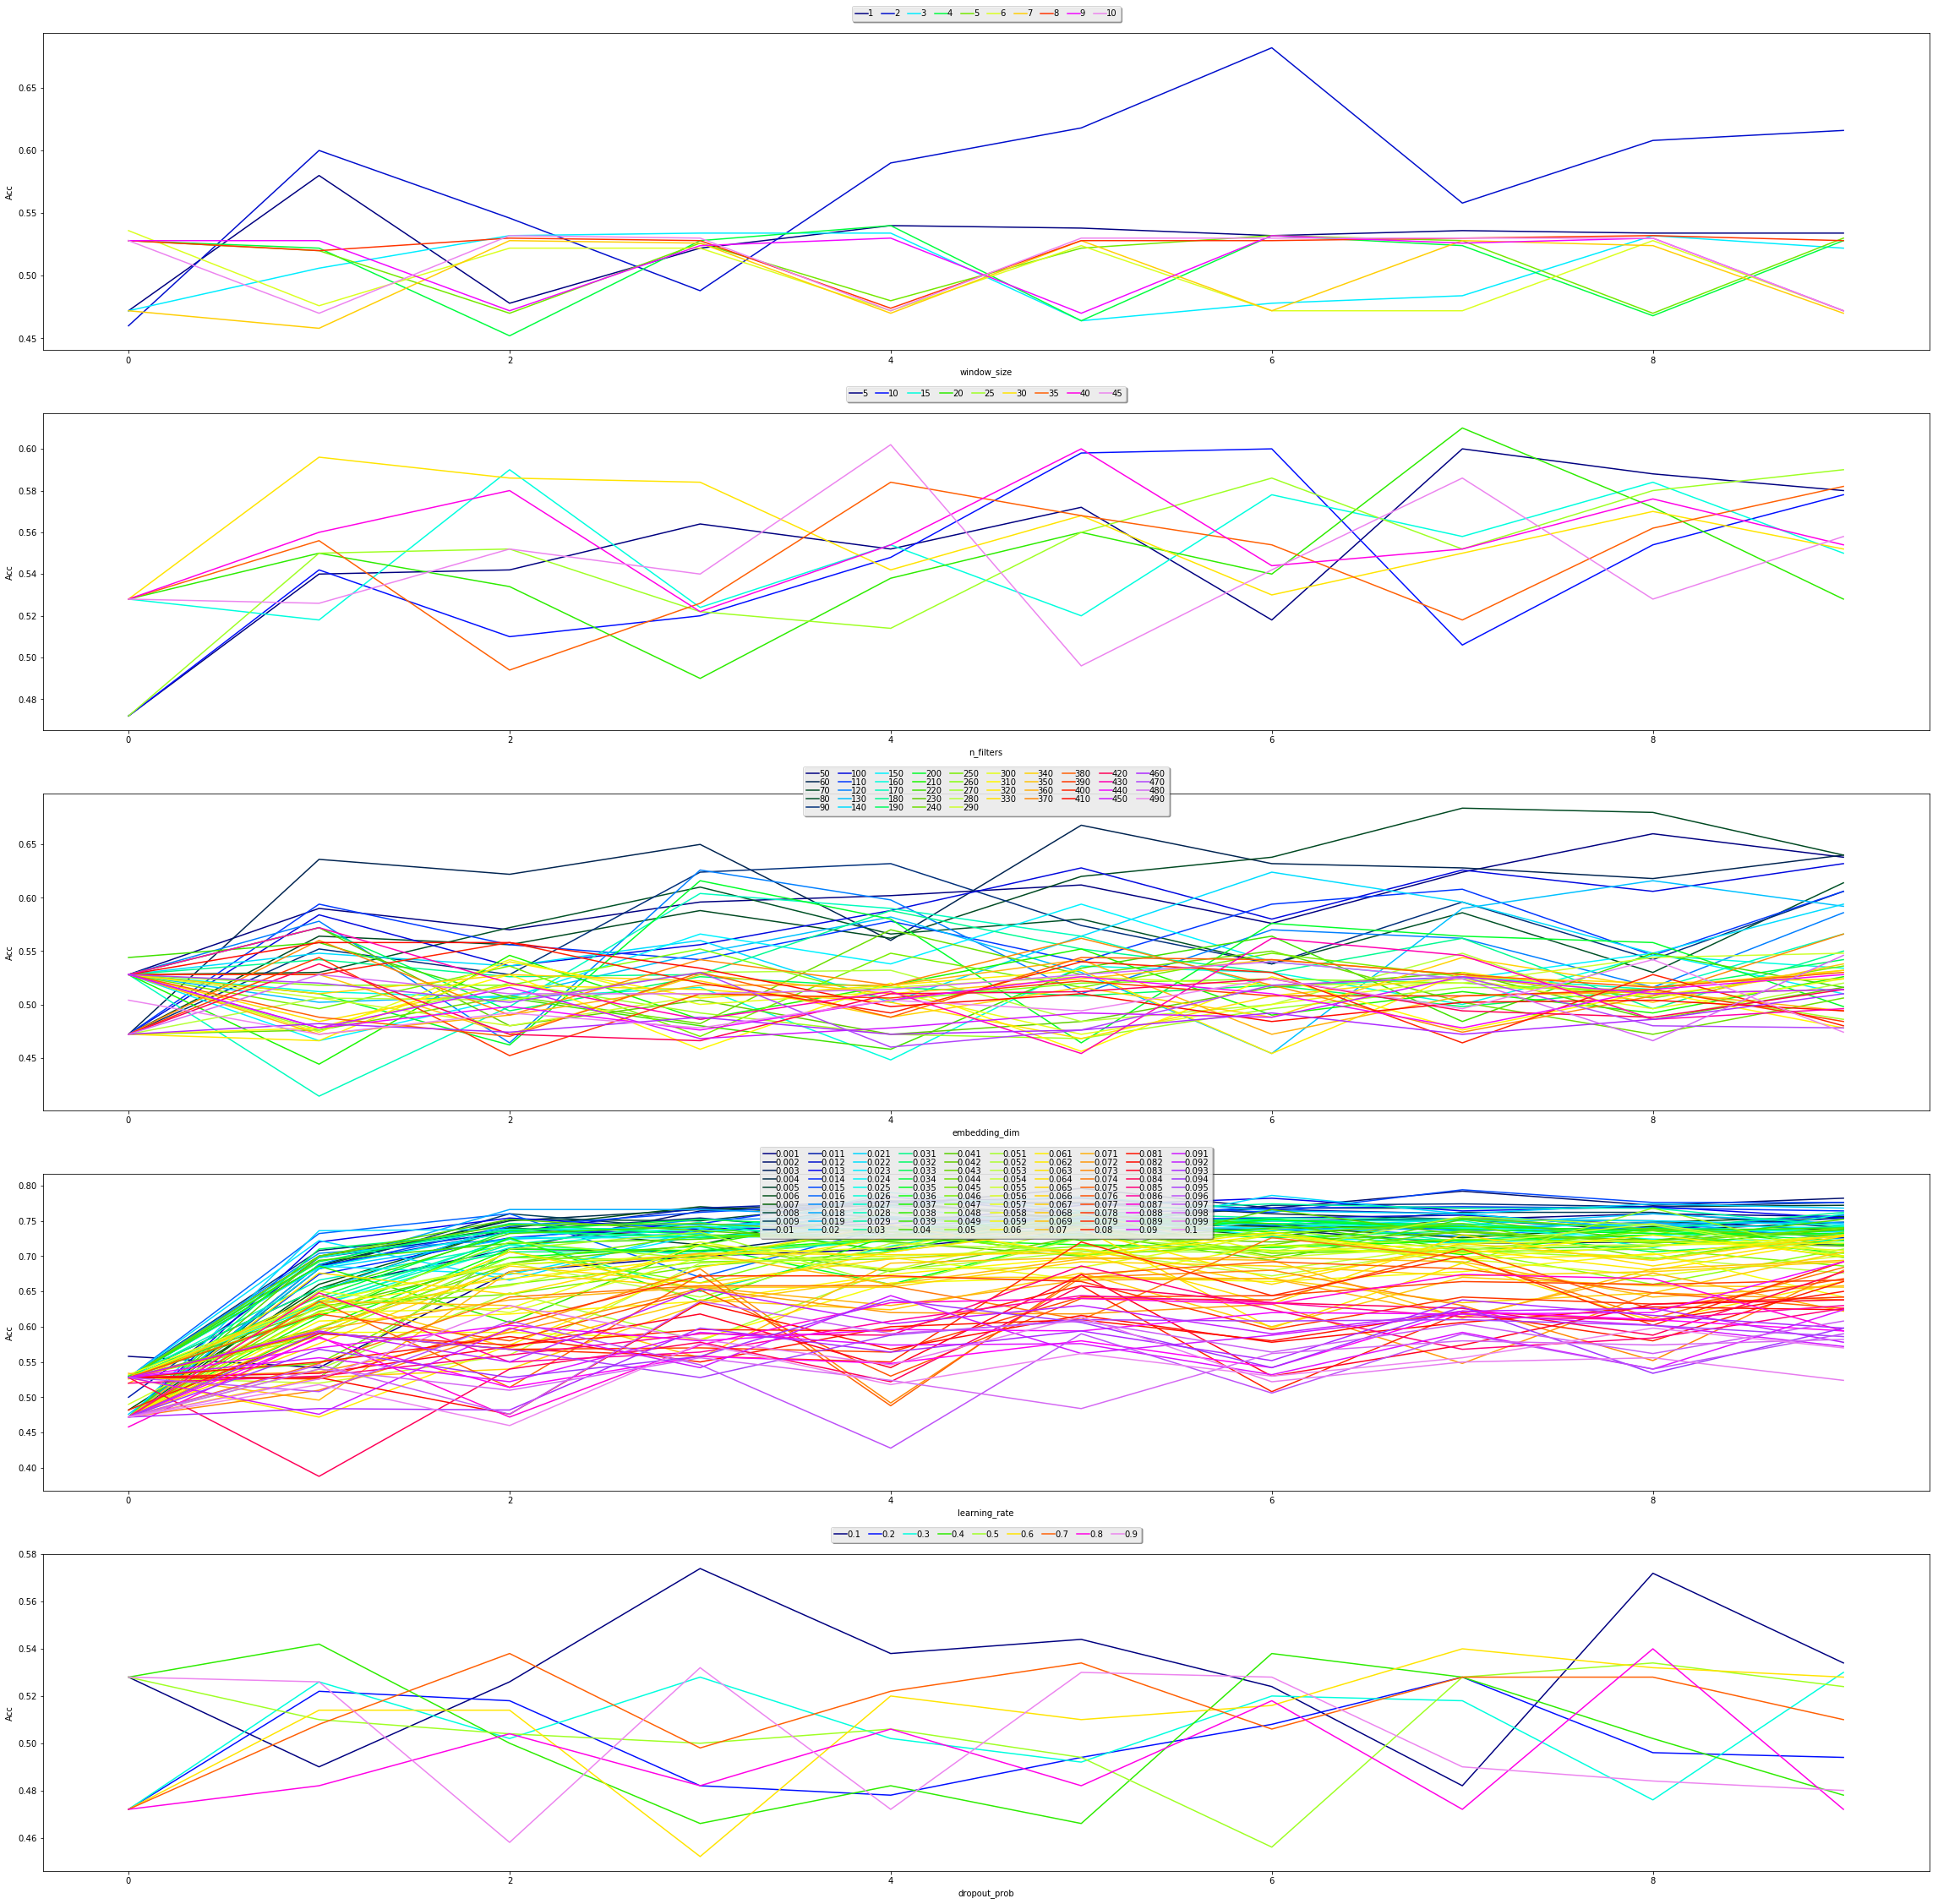

In [44]:
print("Plotting CNN history values Dev----------------------------------")

hypers = ['window_size','n_filters','embedding_dim','learning_rate','dropout_prob']
plt.figure(1,figsize=(40, 40))
for idx,var in enumerate(hypers):
    print("Plotting accuracy history across variables (different lines) with respect to train steps - ",var)
    x,ys,numOfVals = getHistoryValues(cnn,var)
    labels = [str(val) for val in numOfVals]
    plt.subplot(5, 1, idx+1)
    num_plots = len(ys)
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

    for y in ys:
        plt.plot(x,y)

    plt.ylabel('Acc')
    plt.xlabel(var)
    
    plt.legend(labels, ncol=10, loc='upper center', 
           bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

Q5. The param configuration for CBOW with best results (80%) - 
hidden_dim = 50
embedding_dim = 300
learning_rate = 0.001
dropout_prob = 0.1

Q6. The param configuration for the CN best results (79.2%) - window_size = 3 n_filters = 100 embedding_dim = 100 learning_rate = 0.001 dropout_prob = 0.3